In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import xarray as xr
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors

In [2]:
# Utilities for normalizing the emissions data
min_co2 = 0.
max_co2 = 2400
min_ch4 = 0.
max_ch4 = 0.6
def normalize_co2(data): return data / max_co2
def un_normalize_co2(data): return data * max_co2
def normalize_ch4(data): return data / max_ch4
def un_normalize_ch4(data): return data * max_ch4

def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data.mean()

###### set path for data here:
data_path = "./dataset/"

In [3]:
# combine historical + ssp126 + ssp370 + ssp585
X = xr.concat([xr.open_dataset(data_path + 'inputs_historical.nc'),xr.open_dataset(data_path+ 'inputs_ssp126.nc'),xr.open_dataset(data_path+ 'inputs_ssp370.nc'),xr.open_dataset(data_path + 'inputs_ssp585.nc')], dim='time').compute()

# Take the 2nd ensemble member for historical (the first one has some missing DTR values for some reason...) and 1st one for ssp126, ssp370, ssp585
Y = xr.concat([xr.open_dataset(data_path + 'outputs_historical.nc').sel(member=2), xr.open_dataset(data_path + 'outputs_ssp585.nc').sel(member=1),xr.open_dataset(data_path+ 'outputs_ssp126.nc').sel(member=1),xr.open_dataset(data_path+ 'outputs_ssp370.nc').sel(member=1)], dim='time').compute()

# Convert the precip values to mm/day
Y["pr"] *= 86400
Y["pr90"] *= 86400

X["time"] = np.arange(1,424)
Y["time"] = np.arange(1,424)

In [4]:
weights = np.cos(np.deg2rad(Y.lat))
global_mean_temp = Y['tas'].weighted(weights).mean(['lat', 'lon']).to_pandas()

In [5]:
def fit_ps_model(global_ts, Y, model_type="ridge", alpha=0.8):

    if model_type == "linear":
        make_model = lambda: LinearRegression(fit_intercept=False)
    elif model_type == "ridge":
        make_model = lambda: Ridge(alpha=alpha, fit_intercept=False)
    else:
        make_model = lambda: Lasso(alpha=alpha, fit_intercept=False)

    # Prepare outputs Y stacked into (time, n_grid)
    tas = Y["tas"].stack(points=("lat", "lon"))
    pr = Y["pr"].stack(points=("lat", "lon"))
    dtr = Y["diurnal_temperature_range"].stack(points=("lat", "lon"))
    pr90 = Y["pr90"].stack(points=("lat", "lon"))
    a = global_ts.to_numpy().reshape(-1, 1)

    models = {}
    models["tas"] = make_model().fit(a, tas)
    models["pr"]  = make_model().fit(a, pr)
    models["dtr"]  = make_model().fit(a, dtr)
    models["pr90"] = make_model().fit(a, pr90)

    return models

# try with different methods (linear/lasso/ridge regression)
model_linear = fit_ps_model(global_mean_temp, Y, model_type="linear", alpha=67)
model_ridge = fit_ps_model(global_mean_temp, Y, model_type="ridge", alpha=1.2)
model_lasso = fit_ps_model(global_mean_temp, Y, model_type="lasso", alpha=2)

In [6]:
# Test on SSP245
test_Y = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
test_X = xr.open_dataset(data_path + 'inputs_ssp245.nc').compute()

tas_truth = test_Y["tas"].mean('member')
pr_truth = test_Y["pr"].mean('member') * 86400
pr90_truth = test_Y["pr90"].mean('member') * 86400
dtr_truth = test_Y["diurnal_temperature_range"].mean('member')

# Smooth out the internal variability otherwise it's cheating (remove noise from data)
test_inputs = test_Y['tas'].mean('member').weighted(weights).mean(['lat', 'lon']).to_pandas().rolling(10, min_periods=1).mean()

In [7]:
def predicting(model, test_inputs):
    m_out_t = model["tas"].predict(test_inputs.to_numpy()[:, np.newaxis])
    m_out_p = model["pr"].predict(test_inputs.to_numpy()[:, np.newaxis])
    m_out_d = model["dtr"].predict(test_inputs.to_numpy()[:, np.newaxis])
    m_out_p90 = model["pr90"].predict(test_inputs.to_numpy()[:, np.newaxis])

    # puts back to map
    m_out_tas = m_out_t.reshape(86, 96, 144)
    m_out_pr = m_out_p.reshape(86, 96, 144)
    m_out_pr90 = m_out_p90.reshape(86, 96, 144)
    m_out_dtr = m_out_d.reshape(86, 96, 144)

    print("tas:", get_rmse(tas_truth, m_out_tas))
    print("pr:", get_rmse(pr_truth, m_out_pr))
    print("dtr:", get_rmse(dtr_truth, m_out_dtr))
    print("pr90:", get_rmse(pr90_truth, m_out_pr90))
    return

Linear Regression was generally the best we found

In [8]:
print("linear")
predicting(model_linear, test_inputs)
print("ridge")
predicting(model_ridge, test_inputs)
print("lasso")
predicting(model_lasso, test_inputs)

linear
tas: 0.38830305706910584
pr: 0.5282441192160172
dtr: 0.16004320557608478
pr90: 1.5375068386406816
ridge
tas: 0.3887484051119475
pr: 0.5282639818274307
dtr: 0.16007640907367227
pr90: 1.5375586729921278
lasso
tas: 1.2487962650960374
pr: 0.6293067935803932
dtr: 0.2830943474818837
pr90: 1.6906135037820746


In [9]:
def plot_ps_comparison(truth, emulated, varname, time_sel=2050, cmap="coolwarm", diff_cmap="PRGn", savefig=False):

    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(21, 6), subplot_kw={"projection": ccrs.Robinson()})
    divnorm=colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)

    # --- True ---
    ax = axes[0]
    truth.sel(time=time_sel).plot(ax=ax, cmap=cmap, norm=divnorm, transform=ccrs.PlateCarree(), cbar_kwargs={"label":"Temperature change / K"})
    ax.set_title(f"{varname} True {time_sel}")
    ax.coastlines()

    # --- Emulated ---
    ax = axes[1]
    emulated.sel(time=time_sel).plot(ax=ax, cmap=cmap, norm=divnorm, transform=ccrs.PlateCarree(), cbar_kwargs={"label":"Temperature change / K"})
    ax.set_title(f"{varname} Pattern-Scaled {time_sel}")
    ax.coastlines()

    # --- Difference ---
    ax = axes[2]
    diff = truth.sel(time=time_sel) - emulated.sel(time=time_sel)
    diff.plot(ax=ax, cmap=diff_cmap, norm=divnorm, transform=ccrs.PlateCarree(), cbar_kwargs={"label":"Temperature change / K"})
    ax.set_title(f"{varname} Difference (True − Pattern-Scaled)")
    ax.coastlines()

    # Main title
    fig.suptitle(f"{varname} - Pattern Scaling Comparison", fontsize=18)
    fig.tight_layout()

    # Save figure
    if savefig:
        fname = f"ps_{varname}_comparison.png"
        fig.savefig(fname, dpi=250, bbox_inches="tight")
        print(f"Saved figure: {fname}")

    plt.show()

In [10]:
model = fit_ps_model(global_mean_temp, Y, model_type="linear", alpha=67)

m_out_t = model["tas"].predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_p = model["pr"].predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_d = model["dtr"].predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_p90 = model["pr90"].predict(test_inputs.to_numpy()[:, np.newaxis])

# puts back to map
m_out_tas = m_out_t.reshape(86, 96, 144)
m_out_pr = m_out_p.reshape(86, 96, 144)
m_out_pr90 = m_out_p90.reshape(86, 96, 144)
m_out_dtr = m_out_d.reshape(86, 96, 144)

Saved figure: ps_tas_comparison.png


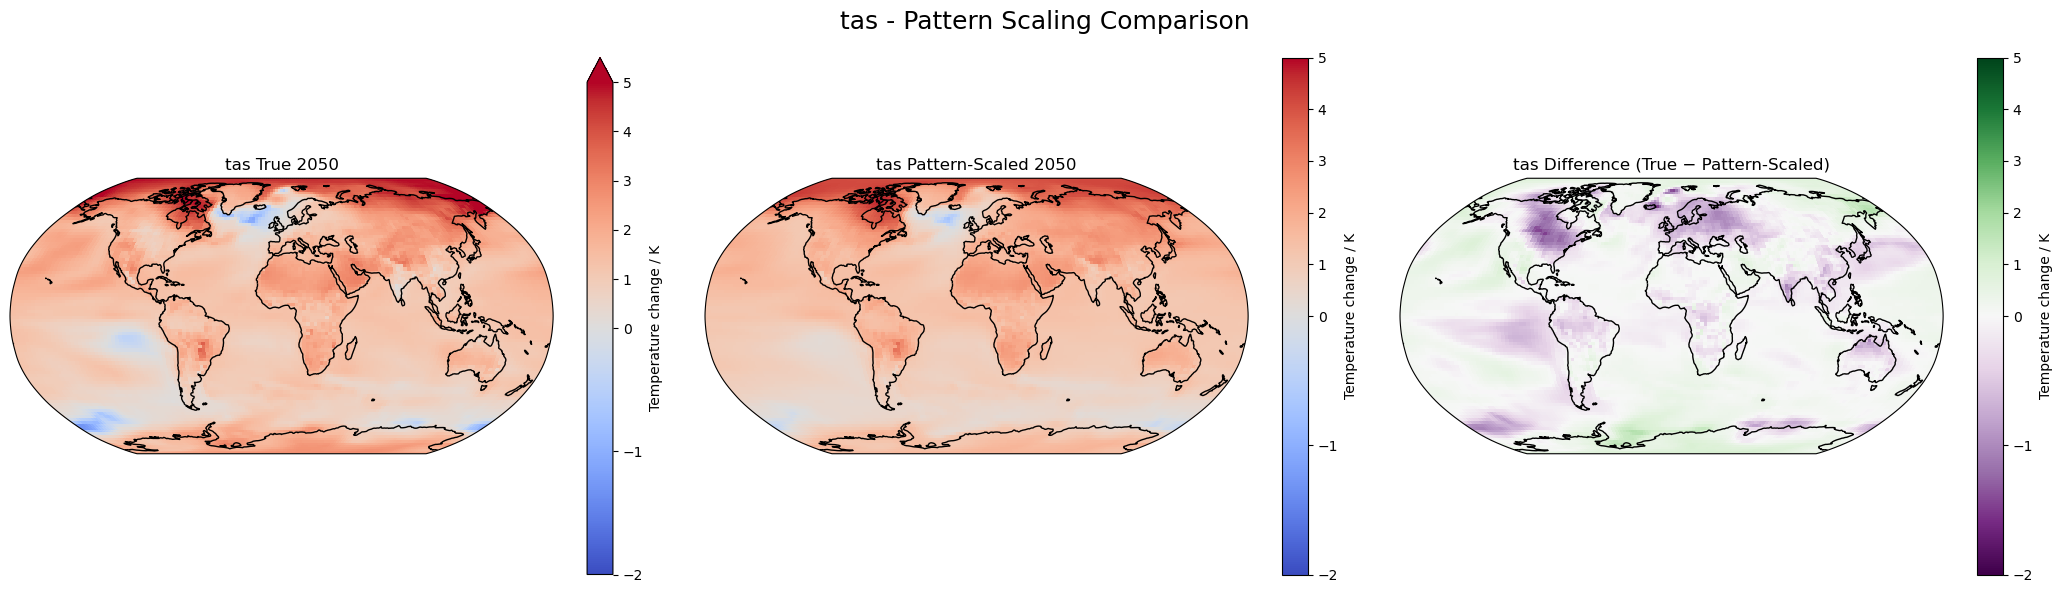

In [11]:
xr_output=xr.Dataset(coords={'time': test_X.time.values, 'lat': test_X.latitude.values, 'lon': test_X.longitude.values})
xr_output["tas"]=(['time', 'lat', 'lon'],  m_out_tas)
xr_output["diurnal_temperature_range"]=(['time', 'lat', 'lon'],  m_out_dtr)
xr_output["pr"]=(['time', 'lat', 'lon'],  m_out_pr)
xr_output["pr90"]=(['time', 'lat', 'lon'],  m_out_pr90)

plot_ps_comparison(truth=tas_truth, emulated=xr_output["tas"], varname="tas", time_sel=2050, cmap="coolwarm", diff_cmap="PRGn", savefig=True)

- RMSE for 2050–2100 === ```[35:]```
- RMSE for 2080–2100 === ```[65:]```

Generally since using linear models, non linear could be issue etc..